Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 5: Classification of Land Cover
=======================================


## Introduction
In this chapter we will classify the Sentinel-2 image we've been working with using a supervised classification approach which incorporates the training data we worked with in [chapter 4](chapter_4_vector.ipynb). Specifically, we will be using [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes). Naive Bayes predicts the probabilities that a data point belongs to a particular class and the class with the highest probability is considered as the most likely class. The way they get these probabilities is by using Bayes’ Theorem, which describes the probability of a feature, based on prior knowledge of conditions that might be related to that feature. Naive Bayes is quite fast when compared to some other machine learning approaches (e.g., SVM can be quite computationally intensive). This isn't to say that it is the best per se; rather it is a great first step into the world of machine learning for classification and regression.

## scikit-learn

In this chapter we will be using the Naive Bayes implementation provided by the [scikit-learn](http://scikit-learn.org) library. `scikit-learn` is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including `numpy`, `scipy`, and `matplotlib`, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and `scikit-learn` helps you understand this by abstracting the details of each algorithm to simple consistent interfaces. For example:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png" alt="An Iris" style="width: 800px;"/>

[This figure](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) shows the classification predictions and the decision surfaces produced for three classification problems using 9 different classifiers. What is even more impressive is that all of this took only about 110 lines of code, including comments!

## Preparing the dataset
#### Opening the images
Our first step is to recall our previous chapter's lessons and import the things we'll need:

In [2]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping

Now we need to collect all the Sentinal-2 bands because they come as individual images one per band.

In [3]:
import os # we need os to do some basic file operations

sentinal_fp = "../RandomForest/data_a/sentinel/"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_fp, f) for f in os.listdir(sentinal_fp) if os.path.isfile(os.path.join(sentinal_fp, f))]
sentinal_band_paths.sort()
sentinal_band_paths

['../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B02_10m_extent.tif',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B02_10m_extent.tif.aux.xml',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B03_10m_extent.tif',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B03_10m_extent.tif.aux.xml',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B04_10m_extent.tif',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B04_10m_extent.tif.aux.xml',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B05_20m_extent.tif',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B06_20m_extent.tif',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B07_20m_extent.tif',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B08_10m_extent.tif',
 '../RandomForest/data_a/sentinel/T32UPU_20210814T102031_B8A_20m_extent.tif']

Now we need a rasterio dataset object containing all bands in order to use the mask() function and extract pixel values using geospatial polygons.

We'll do this by creating a new raster dataset and saving it for future uses.

In [4]:
# create a products directory within the data dir which won't be uploaded to Github
img_dir = '../RandomForest/data_a/products2/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands.tif'

# # Read metadata of first file and assume all other bands are the same
# with rasterio.open(sentinal_band_paths[0]) as src0:
#     meta = src0.meta

# # Update metadata to reflect the number of layers
# meta.update(count = len(sentinal_band_paths))

# # Read each layer and write it to stack
# with rasterio.open(img_fp, 'w', **meta) as dst:
#     for id, layer in enumerate(sentinal_band_paths, start=1):
#         with rasterio.open(layer) as src1:
#             dst.write_band(id, src1.read(1))

Okay we've successfully written it out now let's open it back up and make sure it meets our expectations:

In [5]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(2197, 1478)
8


In [6]:
full_dataset

<open DatasetReader name='../RandomForest/data_a/products2/sentinel_bands.tif' mode='r'>

Let's clip the image and take a look where we know the training data was from the last lesson (on the NC Rachel Carson Reserve) just to make sure it looks normal:

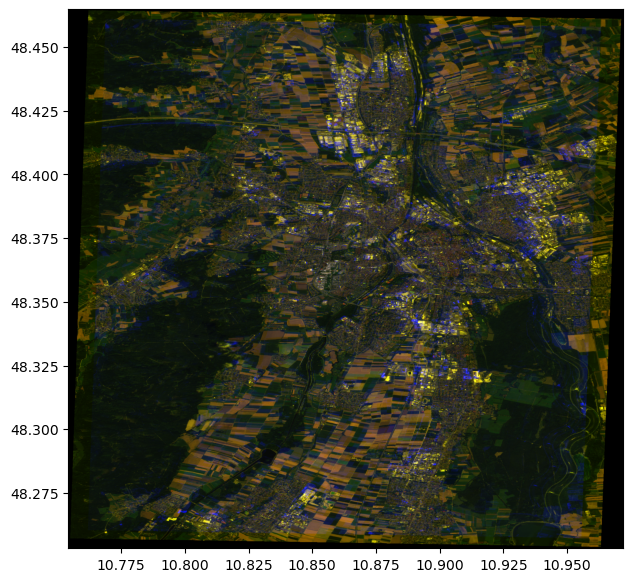

In [7]:
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt

img_fp = '../RandomForest/data_a/products2/sentinel_bands_proj.tif'

# Open the full extent of the raster dataset
with rasterio.open(img_fp) as dataset:
    # Read the specified bands (3, 2, 1 for RGB)
    img_data = dataset.read([3, 2, 1])
# Assuming you've already read the img_data
# Scale the data to 0-255 range, assuming it's 16-bit
img_data = np.clip(img_data / 4096 * 255, 0, 255).astype(np.uint8)

# Mask out no data values if necessary
no_data_value = -9999  # Replace with your actual no data value
img_data[img_data == no_data_value] = 0  # Set no data values to 0 for display

# Now display the image
fig, ax = plt.subplots(figsize=(10, 7))
show(img_data, ax=ax, transform=dataset.transform)

plt.show()

Okay looks good! Our raster dataset is ready!

### Now our goal is to get the pixels from the raster as outlined in each shapefile. 

Our training data, the shapefile we've worked with, contains one main field we care about:
+ a Classname field (String datatype)

Combined with the innate location information of polygons in a Shapefile, we have all that we need to use for pairing labels with the information in our raster.

However, in order to pair up our vector data with our raster pixels, we will need a way of co-aligning the datasets in space. 

We'll do this using the rasterio mask function which takes in a dataset and a polygon and then outputs a numpy array with the pixels in the polygon.

Let's run through an example:

In [8]:
full_dataset = rasterio.open(img_fp)
raster_crs = full_dataset.crs

In [9]:
# from rasterio.warp import calculate_default_transform, reproject, Resampling

# # Define the source and destination coordinate reference systems
# src_crs = 'EPSG:32632'
# dst_crs = 'EPSG:4326'

# # Open the original dataset
# with rasterio.open('../RandomForest/data_a/products2/sentinel_bands.tif') as src:
#     # Calculate the transform and dimensions for the new dataset
#     transform, width, height = calculate_default_transform(
#         src.crs, dst_crs, src.width, src.height, *src.bounds)
    
#     # Define the metadata for the new dataset
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': dst_crs,
#         'transform': transform,
#         'width': width,
#         'height': height
#     })

#     # Create the new dataset and reproject the original data into it
#     with rasterio.open('../RandomForest/data_a/products2/sentinel_bands_proj.tif', 'w', **kwargs) as dst:
#         for i in range(1, src.count + 1):  # Loop through all bands
#             reproject(
#                 source=rasterio.band(src, i),
#                 destination=rasterio.band(dst, i),
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs=dst_crs,
#                 resampling=Resampling.nearest)

Open up our shapefile and check its crs

In [10]:
shapefile = gpd.read_file('../RandomForest/data_a/rcr/rcr_augsburg.shp')
shapefile.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
shapefile

,Id,Classname,classvalue,geometry
0,0,crop,3,"POLYGON ((636654.985 5363761.581, 636930.350 5..."
1,0,crop,3,"POLYGON ((636069.668 5363567.362, 636443.473 5..."
2,0,grass,2,"POLYGON ((637788.372 5363097.778, 637902.775 5..."
3,0,streets,5,"POLYGON ((638873.453 5363027.668, 638891.434 5..."
4,0,streets,5,"POLYGON ((637786.457 5361275.207, 637820.512 5..."
5,0,buildings,1,"POLYGON ((637706.428 5359867.891, 637815.403 5..."
6,0,buildings,1,"POLYGON ((637833.282 5361149.204, 637917.568 5..."
7,0,buildings,1,"POLYGON ((637169.213 5359466.895, 637227.958 5..."
8,0,paths,6,"POLYGON ((638210.439 5360188.858, 638225.764 5..."
9,0,paths,6,"POLYGON ((638178.087 5359959.839, 638195.966 5..."


Remember the projections don't match! Let's use some geopandas magic to reproject all our shapefiles to lat, long.

In [12]:
shapefile = shapefile.to_crs({'init': 'epsg:4326'})

c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
shapefile.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
len(shapefile)

40

Now we want to extract the geometry of each feature in the shapefile in GeoJSON format:

In [15]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((10.846742516562545 48.41218130034005, 10.850468271131017 48.41230095173121, 10.852757660431976 48.409008657286684, 10.851900214832582 48.40866340908946, 10.852349815161352 48.40718403917167, 10.849616442646356 48.40715621341835, 10.846742516562545 48.41218130034005))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((10.846742516562545, 48.41218130034005), (10.850468271131017, 48.41230095173121), (10.852757660431976, 48.409008657286684), (10.851900214832582, 48.40866340908946), (10.852349815161352, 48.40718403917167), (10.849616442646356, 48.40715621341835), (10.846742516562545, 48.41218130034005)),)}]


Now let's extract the raster values values within the polygon using the rasterio [mask() function](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html)

In [16]:
print(full_dataset.crs)
print(shapefile.crs)

EPSG:4326
+init=epsg:4326 +type=crs


In [17]:
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape

(8, 48, 56)

Okay those looks like the right dimensions for our training data. 8 bands and 6x8 pixels seems reasonable given our earlier explorations.

We'll be doing a lot of memory intensive work so let's clean up and close this dataset.

In [18]:
full_dataset.close()

### Building the Training Data for `scikit-learn`

Now let's do it for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.

In [19]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.geometry import box


# Load the shapefile
#shapefile = gpd.read_file(shapefile_path)

# Check if the CRS matches, if not, reproject
if shapefile.crs != raster_crs:
    shapefile = shapefile.to_crs(raster_crs)

# Check that geometries are valid
shapefile['valid'] = shapefile.is_valid
shapefile = shapefile[shapefile['valid']]


with rasterio.open('../RandomForest/data_a/products2/sentinel_bands_proj.tif') as src:
    raster_bounds = src.bounds
    raster_bbox = box(*raster_bounds)  # Create a bounding box from the raster bounds

    # Only proceed if the raster and shapefile overlap
    if not shapefile.unary_union.intersects(raster_bbox):
        raise ValueError("Shapefile and raster do not overlap")
    else:
        print("The shapefile and raster overlap.")

    # Extract the raster values within the polygon
    for geom in shapefile.geometry:
        feature = [mapping(geom)]
        out_image, out_transform = mask(src, feature, crop=True)
        # process out_image


The shapefile and raster overlap.


In [20]:
import numpy as np

# Initialize a list to hold the mean values for each band
band_means = []

# Extract the raster values within the polygon
for geom in shapefile.geometry:
    feature = [mapping(geom)]
    
    with rasterio.open('../RandomForest/data_a/products2/sentinel_bands_proj.tif') as src:
        out_image, out_transform = mask(src, feature, crop=True)
        
        # Calculate mean of each band, excluding no-data values
        means = np.ma.array(out_image, mask=out_image == src.nodata).mean(axis=(1, 2))
        band_means.append(means.filled(src.nodata))  # Fill masked values with the no-data value

# Do something with band_means, such as saving to file or further analysis

In [21]:
X = np.array([], dtype=np.float32).reshape(0, 8)  # Check the appropriate dtype for your data
y = np.array([], dtype='object')  # Using 'object' dtype for variable-length strings

with rasterio.open(img_fp) as src:
    band_count = src.count
    nodata = src.nodata  # Use the raster's nodata value
    
    for index, geom in enumerate(shapefile.geometry):
        feature = [mapping(geom)]

        out_image, out_transform = mask(src, feature, crop=True, nodata=nodata)
        # Mask the no-data pixels
        out_image_masked = np.ma.masked_equal(out_image, nodata)
        
        if not np.all(out_image_masked.mask):  # Only proceed if there are non-masked pixels
            # Reshape to [pixel count, bands]
            out_image_reshaped = out_image_masked.compressed().reshape(-1, band_count)
            # Append the labels to the y array, replicating for each pixel
            y = np.append(y, [shapefile.iloc[index]["Classname"]] * out_image_reshaped.shape[0])
            # Stack the pixels onto the pixel array
            X = np.vstack((X, out_image_reshaped))

In [22]:
out_image_masked

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

#### Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the land cover labels (our y labeled data), let's check to make sure they match in size so we can feed them to Naive Bayes:

In [23]:
# What are our classification labels?
labels = np.unique(shapefile["Classname"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 10 classes: ['buildings' 'buldings' 'crop' 'forest' 'grass' 'paths' 'playground'
 'streets' 'trees' 'water bodies']

Our X matrix is sized: (17085, 8)
Our y array is sized: (17085,)


It all looks good! Let's explore the spectral signatures of each class now to make sure they're actually separable since all we're going by in this classification is pixel values.

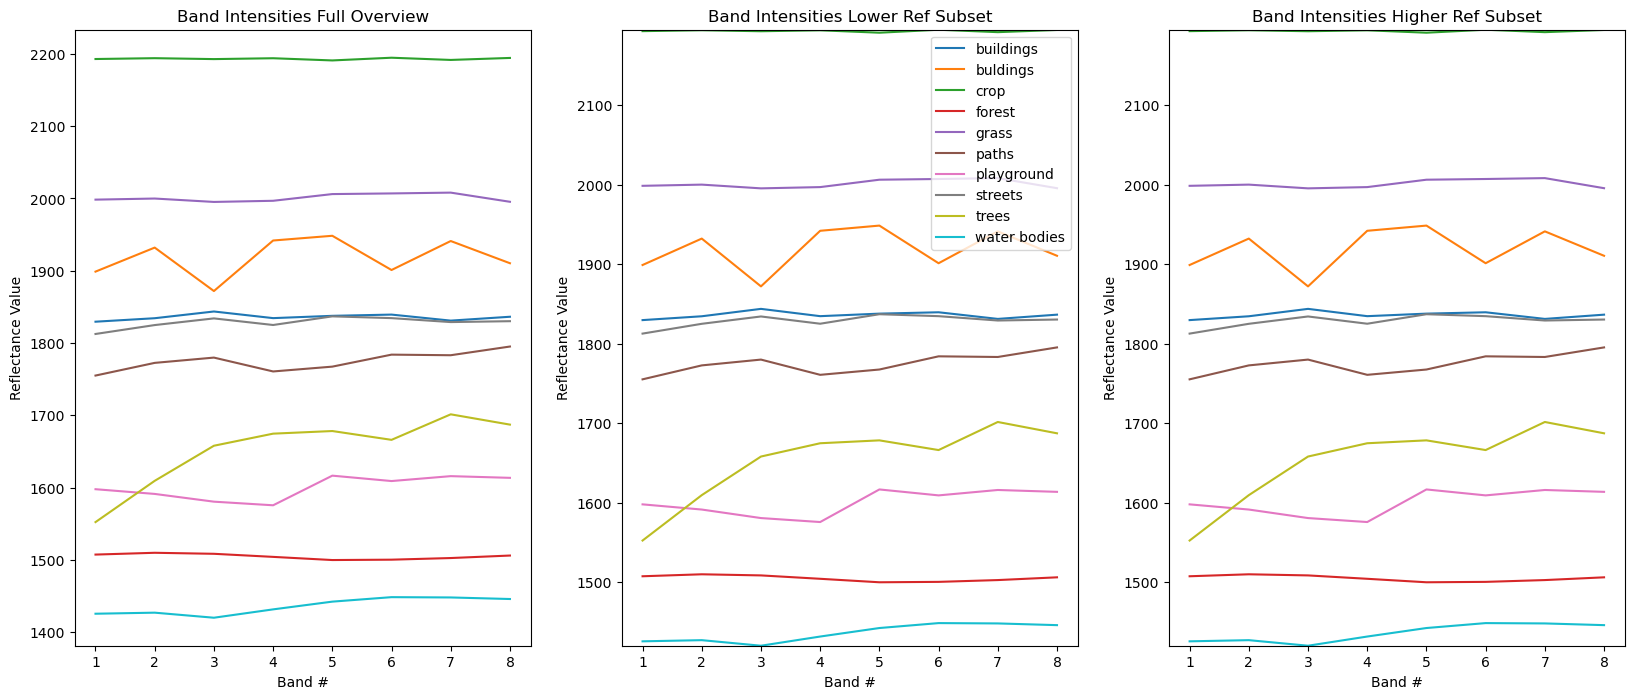

In [81]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-8
band_count = np.arange(1,9)

# For ax[1] and ax[2], set the y-limits to encompass the minimum and maximum band intensity values
min_intensity = min([np.mean(X[y==class_type, :], axis=0).min() for class_type in classes])
max_intensity = max([np.mean(X[y==class_type, :], axis=0).max() for class_type in classes])

# Set the limits for ax[1] and ax[2] based on your data
ax[1].set_ylim(min_intensity, max_intensity)  # Adjust this as needed
ax[2].set_ylim(min_intensity, max_intensity)  # Adjust this as needed

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)

# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')

# Set the y-limits for ax[0] if you want to focus on a specific range, otherwise, it will auto-scale
# ax[0].set_ylim(min_intensity, max_intensity)

ax[1].legend(loc="upper right")

# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

plt.show()

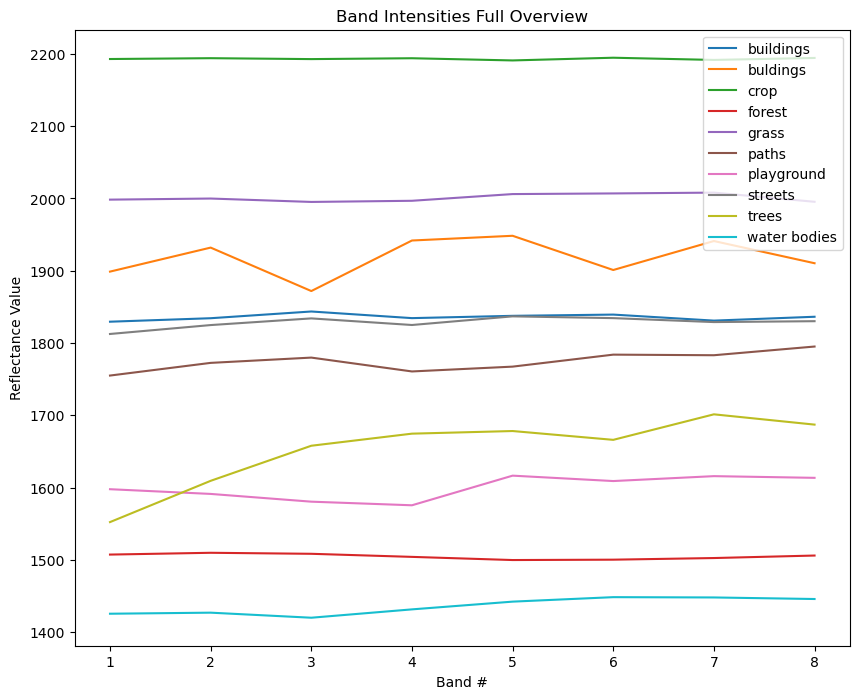

In [84]:
fig, ax = plt.subplots(figsize=[10,8])  # Only create one plot

# numbers 1-8
band_count = np.arange(1,9)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_type)

# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')

# Set the y-limits if you want to focus on a specific range, otherwise, it will auto-scale
# min_intensity = min([np.mean(X[y==class_type, :], axis=0).min() for class_type in classes])
# max_intensity = max([np.mean(X[y==class_type, :], axis=0).max() for class_type in classes])
# ax.set_ylim(min_intensity, max_intensity)

ax.legend(loc="upper right")

# Add a title
ax.set_title('Band Intensities Full Overview')

plt.show()

In [78]:
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    print(f"Class: {class_type}, Band Intensity: {band_intensity}")

    # Check if the intensity array is not empty or does not contain NaNs
    if not np.isnan(band_intensity).all() and band_intensity.size > 0:
        ax[0].plot(band_count, band_intensity, label=class_type)
        ax[1].plot(band_count, band_intensity, label=class_type)
        ax[2].plot(band_count, band_intensity, label=class_type)
    else:
        print(f"Warning: No data to plot for class {class_type}")

Class: buildings, Band Intensity: [1829.553  1834.3685 1843.6705 1834.5004 1837.6753 1839.3883 1831.0514
 1836.3953]
Class: buldings, Band Intensity: [1898.8337 1932.0494 1871.9526 1941.853  1948.3894 1901.0577 1941.1367
 1910.4272]
Class: crop, Band Intensity: [2192.885  2194.036  2192.7683 2193.9575 2190.9202 2194.675  2191.6157
 2194.374 ]
Class: forest, Band Intensity: [1507.4565 1509.9332 1508.53   1504.2705 1499.8955 1500.4042 1502.6617
 1506.1184]
Class: grass, Band Intensity: [1998.3907 1999.9077 1995.2104 1996.7949 2006.0793 2006.9741 2008.0878
 1995.4119]
Class: paths, Band Intensity: [1755.0679 1772.6031 1779.906  1760.7404 1767.4114 1783.9978 1783.1758
 1795.2089]
Class: playground, Band Intensity: [1597.868  1591.349  1580.6305 1575.6368 1616.6171 1609.1472 1615.9387
 1613.5948]
Class: streets, Band Intensity: [1812.5771 1824.8971 1834.1227 1824.9976 1836.9451 1834.5006 1829.0312
 1830.263 ]
Class: trees, Band Intensity: [1552.3828 1609.4609 1657.9922 1674.707  1678.335  1

They look okay but emergent wetland and water look quite similar! They're going to be difficult to differentiate.

Let's make a quick helper function, this one will convert the class labels into indicies and then assign a dictionary relating the class indices and their names.

'buildings' 'buldings' 'crop' 'forest' 'grass' 'paths' 'playground'
 'streets' 'trees' 'water bodies'

In [89]:
def str_class_to_int(class_array):
    class_array[class_array == 'trees'] = 0
    class_array[class_array == 'buildings'] = 1
    class_array[class_array == 'grass'] = 2
    class_array[class_array == 'crop'] = 3
    class_array[class_array == 'forest'] = 4
    class_array[class_array == 'streets'] = 5
    class_array[class_array == 'paths'] = 6
    class_array[class_array == 'water bodies'] = 7
    class_array[class_array == 'playground'] = 8
    return(class_array.astype(int))

## Training the Classifier
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

Visit [this web page to find the usage of GaussianNaiveBayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) from `scikit-learn`.

In [90]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB()

It is that simple to train a classifier in `scikit-learn`! The hard part is often validation and interpretation.

## Predicting on the image

With our Naive Bayes classifier fit, we can now proceed by trying to classify the entire image:

We're only going to open the subset of the image we viewed above because otherwise it is computationally too intensive for most users.

In [91]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [92]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 150:600, 250:1400]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(8, 450, 1150)
(450, 1150, 8)


Now we can predict for each pixel in our image:

In [93]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

Because our shapefile came with the labels as strings we want to convert them to a numpy array with ints using the helper function we made earlier.

In [94]:
class_prediction = str_class_to_int(class_prediction)

### Let's visualize it!

First we'll make a colormap so we can visualize the classes, which are just encoded as integers, in more logical colors. Don't worry too much if this code is confusing! It can be a little clunky to specify colormaps for `matplotlib`.

In [95]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (0, 205, 0, 255)),   # Green3 - trees
    (1, (139, 0, 0, 255)),      # DarkRed - buildings
    (2, (96, 19, 134, 255)),    # Purple - grass
    (3, (244, 164, 96, 255)),   # Tan - crop
    (4, (34, 139, 34, 255)),    # Forest Green - forest
    (5, (84, 84, 84, 255)),    # Gray33 - streets 
    (6, (139, 69, 19, 255)),    # Brown - paths
    (7, (34, 139, 34, 255)),    # Forest Green - water bodies
    (8, (96, 19, 134, 255)),    # Pruple - playground  
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

Now show the classified map next to the RGB image!

C:\Users\leoni\AppData\Local\Temp\ipykernel_22860\2376915608.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


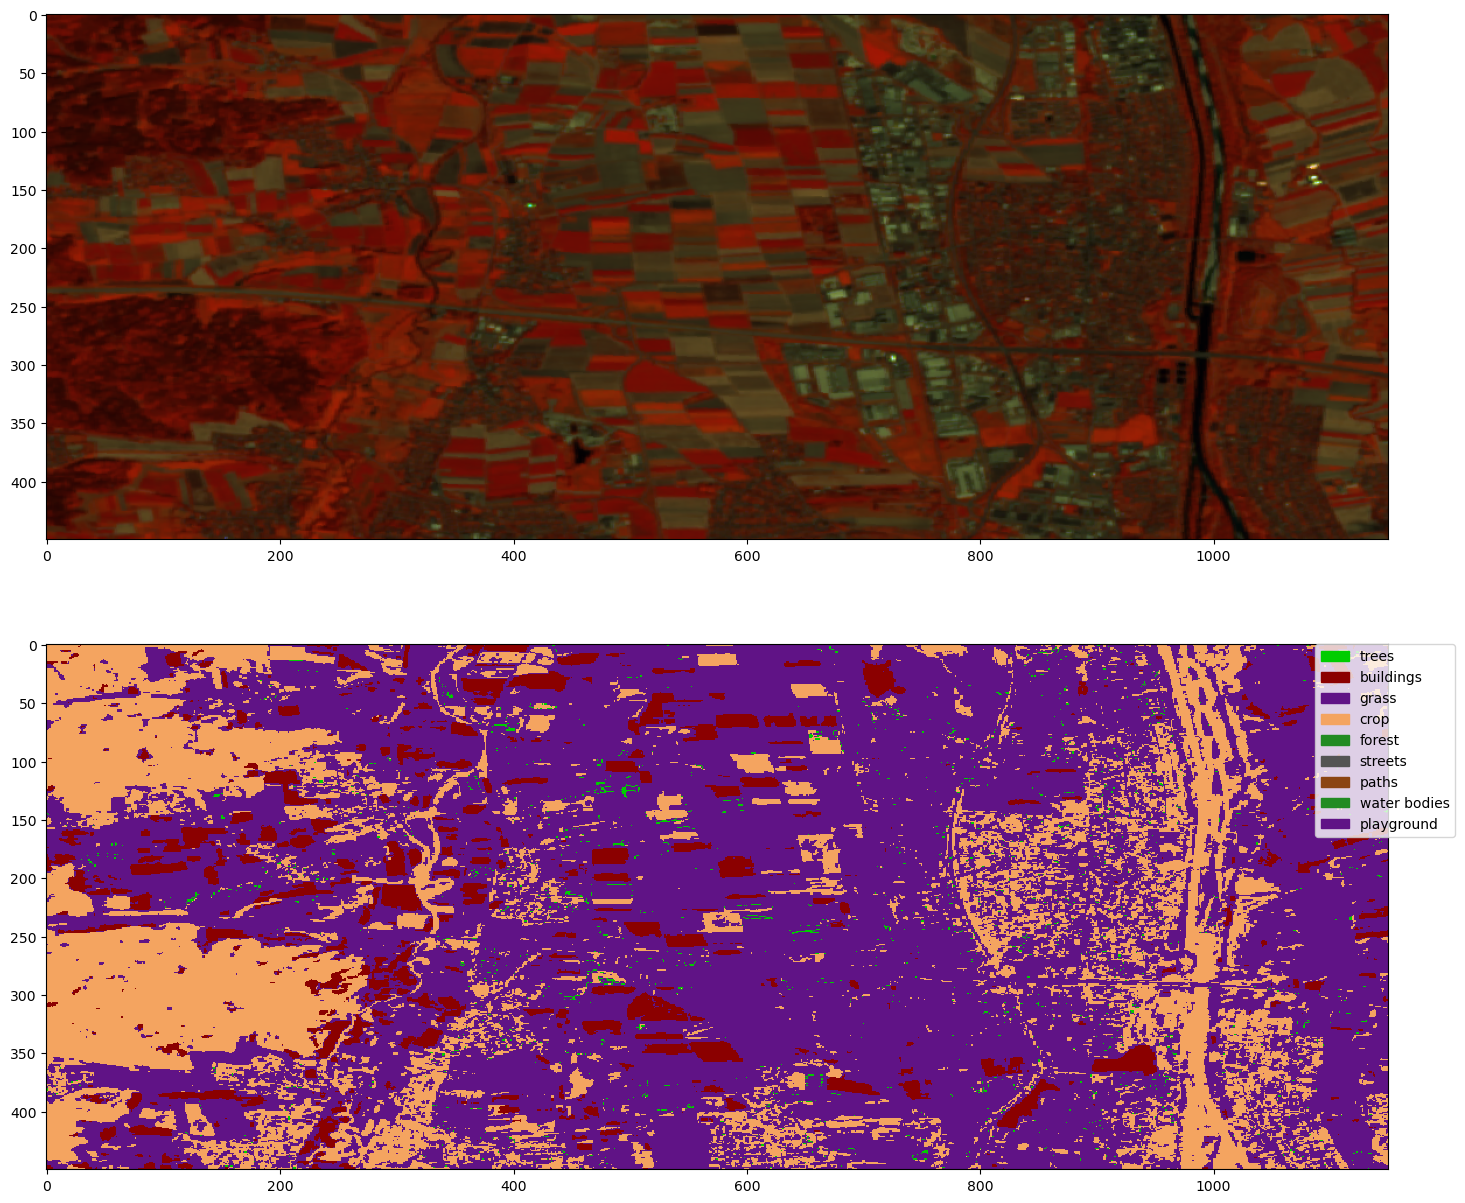

In [107]:
import matplotlib.patches as mpatches

# Define the class labels - make sure these are in the correct order to match your class numbers
class_labels = {
    0: "trees",
    1: "buildings",
    2: "grass",
    3: "crop",
    4: "forest",
    5: "streets",
    6: "paths",
    7: "water bodies",  # Assuming water bodies and forest have the same color intentionally
    8: "playground"
}

# Create a list of patches to add to the legend
patches = [mpatches.Patch(color=colors[key], label=class_labels[key]) for key in class_labels]

fig, axs = plt.subplots(2,1,figsize=(20,15))

img_stretched = color_stretch(reshaped_img, [7, 3, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')
axs[1].legend(handles=patches, loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

fig.show()

### This looks pretty good!

Let's generate a map of Normalized Difference Water Index (NDWI) and NDVI just to compare with out output map.

NDWI is similar to NDVI but for identifying water.

In [97]:
with rasterio.open(img_fp) as src:
    green_band = src.read(3)
    red_band = src.read(4)
    nir_band = src.read(8)
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))


Subset them to our area of interest:

In [56]:
ndwi = ndwi[150:600, 250:1400]
ndvi = ndvi[150:600, 250:1400]

Display all four maps:

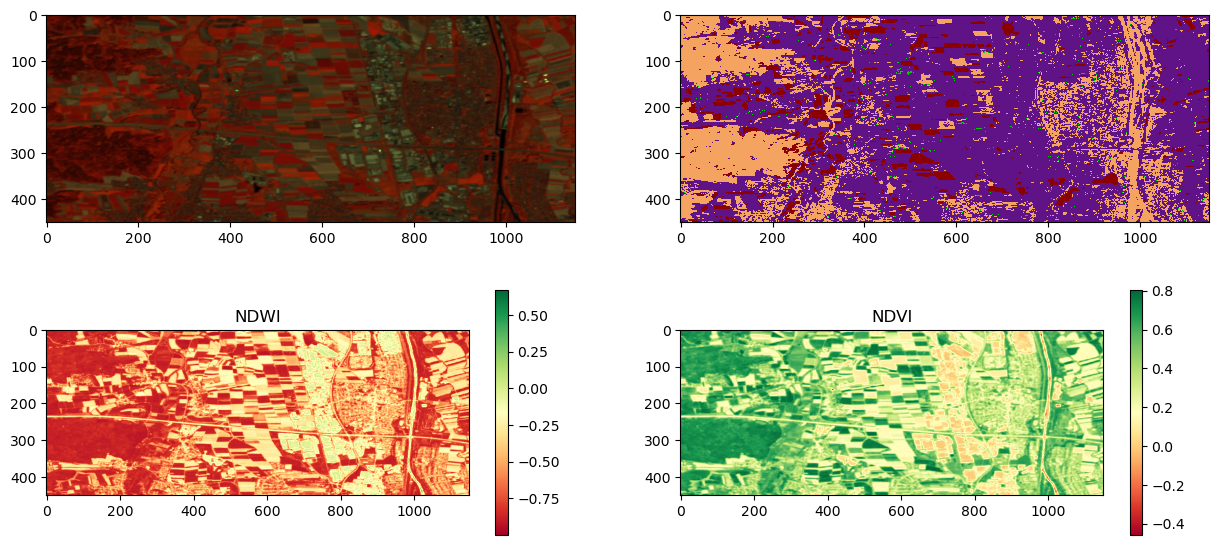

In [68]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

img_stretched = color_stretch(reshaped_img, [7, 3, 2])
axs[0,0].imshow(img_stretched)

axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlGn")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

Looks pretty good! Areas that are high on the NDWI ratio are generally classified as water and areas high on NDVI are forest and herbaceous. It does seem like the wetland areas (e.g. the bottom right island complex) aren't being picked up so it might be worth experimenting with other algorithms!

Let's take a closer look at the Duke Marine Lab and the tip of the Rachel Carson Reserve.

C:\Users\leoni\AppData\Local\Temp\ipykernel_22860\3090654090.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


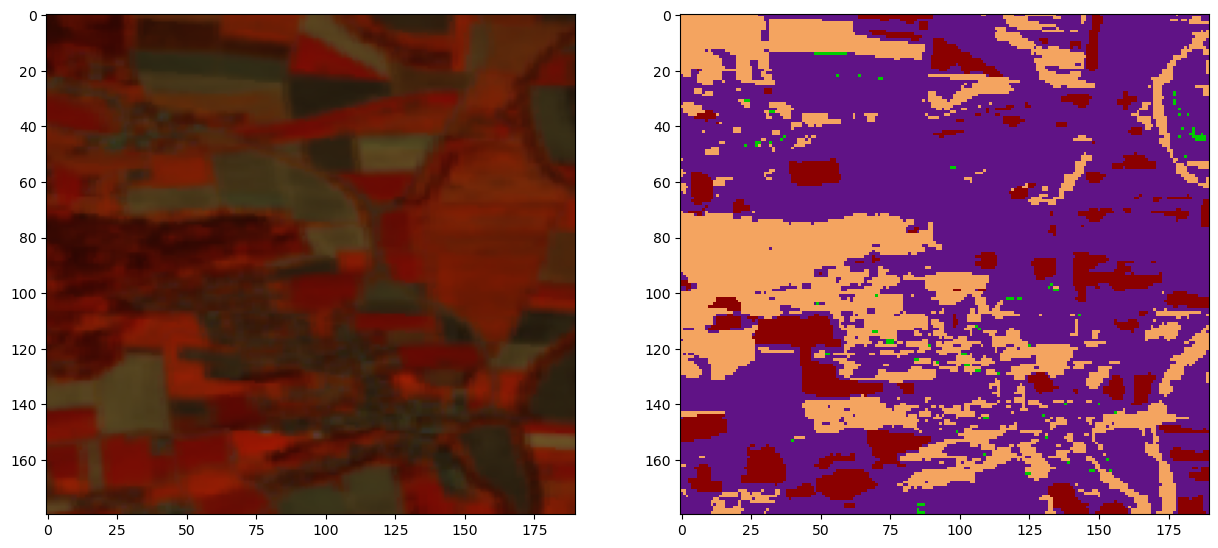

In [67]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [7, 3, 2])
axs[0].imshow(img_stretched[0:180, 160:350])

axs[1].imshow(class_prediction[0:180, 160:350], cmap=cmap, interpolation='none')

fig.show()

This actually doesn't look half bad! Land cover mapping is a complex problem and one where there are many approaches and tools for improving a map.

## Testing an Unsupervised Classification Algorithm

Let's also try a unsupervised classification algorithm, k-means clustering, in the scikit-learn library ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html))

K-means ([wikipedia page](https://en.wikipedia.org/wiki/K-means_clustering)) aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


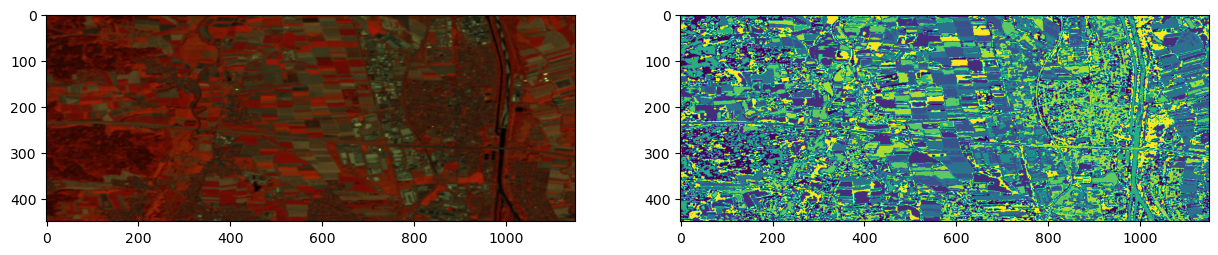

In [115]:
from sklearn.cluster import KMeans

bands, rows, cols = img.shape

k = 9 # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(reshaped_img.reshape(-1, 8))

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

# Now show the classmap next to the image
fig, axs = plt.subplots(1,2,figsize=(15,8))

img_stretched = color_stretch(reshaped_img, [7, 3, 2]) #try different band combinations
axs[0].imshow(img_stretched)

axs[1].imshow(kmeans_predictions_2d)

Wow this looks like it was better able to distinguish some areas like the wetland and submerged sand than our supervised classification approach! But supervised usually does better with some tuning, luckily there are lots of ways to think about improving our supervised method.

## Wrapup

We've seen how we can use `scikit-learn` to implement the Naive Bayes classifier for land cover classification. A couple future directions that immediately follow this tutorial include:

+ Extend the lessons learned in the [visualization chapter](chapter_3_visualization.ipynb) to explore the class separability along various dimensions of the data. For example, plot bands against each other and label each point in the scatter plot a different color according to the training data label.
+ Add additional features - would using NDVI as well as the spectral bands improve our classification?
+ `scikit-learn` includes many machine learning classifiers -- are any of these better than Naive Bayes for our goal? SVM? Nearest Neighbors? Others?
+ In this example we only use 8-bit imagery, 16 or 32 bit may contain more information that helps distinguish the classes
+ Our training data was created using ultra-high resolution drone imagery. A good deal of error could be coming from the fact that the training samples don't line up exactly with the classes in this imagery. Editing the training shapefile to be better matched to this image could lead to a major improvement.
+ This approach only leverages the spectral information in Landsat. What would happen if we looked into some spatial information metrics like incorporating moving window statistics?
+ And while more advanced, deep learning methods (like in the next chapter!!!) could lead to major improvements in this classification!

### Quantative Accuracy Assessments!
We examined our maps for qualitative accuracy but we'll need to perform a proper accuracy assessment based on a probability sample to conclude anything about the accuracy of the entire area. With the information from the accuracy assessment, we will be able not only to tell how good the map is, but more importantly we will be able to come up with statistically defensible unbiased estimates with confidence intervals of the land cover class areas in the map. For more information, see [Olofsson, *et. al.*, 2013](http://www.sciencedirect.com/science/article/pii/S0034425712004191).

In the next chapter (link to [webpage](chapter_6_neural_networks.html) or [Notebook](chapter_6_neural_networks.ipynb)) we'll explore how we can classify land cover on a larger scale and more accurately with deep neural networks. We'll also use some more quantative accuracy assessment methods.